This is the fourth in a series of notebooks designed for the "Hackathon" at the TESS Interactive Data Workshop at the winter AAS meeting. 

The hackathon notebooks are intended to be a non-comprehensive guide on to how to approach different problems with TESS. It is up to the user to fill in the blanks to customize the notebook to their interests. Because of this, a basic knowledge of TESS data handling is prerequisite to these notebooks. 

If you are new to TESS, please be aware of the following tutorials before proceeding further.

TESS Science Support Center tutorials: https://heasarc.gsfc.nasa.gov/docs/tess/tutorial_landing.html

MAST tutorials : https://github.com/spacetelescope/project-tikebook/tree/main/notebooks

lightkurve tutorials: https://github.com/lightkurve/lightkurve/tree/main/docs/source/tutorials

In [1]:
%matplotlib inline

In [2]:
# Important: ensure files are retrieved from AWS 
from astroquery.mast import Observations
Observations.enable_cloud_dataset(provider='AWS')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import lightkurve as lk
from astropy.time import Time
from astropy.units import Quantity
from tqdm.notebook import tqdm
import glob
import os
import csv

#machine learning packages
#from tensorflow import keras
import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc


INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


In this notebook, we will take a look at using TESS data as input for machine learning applications. This is a huge topic with a lot of variation and tailoring options, so there is plenty of room to hack! At the bottom of the notebook, we will include some references if you are interested in learning more about machine learning and applications to astronomy.

This notebook will try to remain agnostic as to the science goal you want to pursue. You could be looking for exoplanet transits, transient objects, special types of variable stars, you name it and you can try to customize this notebook to find or characterize it. We just happen to be working with one example (distinguishing planet transits from eclipsing binaries), but you can tweak the codes to do whatever you'd like. 


In general, machine learning is a just a fancy way of looking for underlying patterns in the input data. Machine learning can be anything as simple as fitting a trend line to your two-dimensional data to complex multi-stage neural nets. We will focus on the data processing as a starting point to machine learning and demonstrate some very basic implementations. However, there is no way we can even cover all of the basics, so we refer you to the machine learning package documentation. 

We will be using two different machine learning libraries. The first is sklearn, which is an extremely popular and simple to use python package. It has many different types of machine learning algorithms in the library such as K-nearest neighbors, logistic regression, support vector machines, and random forest classifiers (which we will use here). Check out the documentation to see the full range of models. https://scikit-learn.org/stable/index.html

We will also build a simple neural network model using keras. This is a great and simple tool to start working with deep learning models. https://keras.io  If you eventually want to create more complex models or use pre-trained networks, other options such at PyTorch can have more functionality, at the cost of less user-friendly documentation.

Once you have your project goal, you can then decide what training data you have available. This is an extremely important step that shouldn't be taken lightly when using your algorithm out in the real world. There are many factors that go into it, such as will you use real data, synthetic data, or a combination? Do you have or can you generate a 'ground truth' sample or do you instead just want to group silimar things together with no label? And so much more.

It is important to emphasize that this notebook is just a guide to get you started, not a comprehensive finished work. Please use your best judgement when using the cells in the notebook in other contexts!

# Step 1 - define your problem

The first step in developing your machine learning model is defining what you want to do. Before you decide that there are a few of factors to consider
- Is your goal classification or regression, meaning are you trying to give categorical labels to objects in your sample or do you want to get a numerical estimate of some feature?
- If you are interested in classification, how many categories of data do you expect to find? Binary classification is the most straightforward but often too simplified for astronomical purposes. 
- Do you have a sample of ground truth observations to train your model, or are you just looking for the machine learning model to look for underlying structure in the data?
- What type of input data are you working with (images, lightcurves, csv-like features, etc)
- What outcome is needed? Do you need to focus on optimizing precision or accuracy?

All of these will change what type of machine learning model you want to use. 
For the sake of this tutorial, we will start by making a binary classifier that can distinguish between exoplanet transits and eclipsing binaries. For training, we will use data from the current confirmed TESS planets and the TESS Eclipsing Binaries ("TESS-EBs") catalog (https://ui.adsabs.harvard.edu/abs/2022ApJS..258...16P/abstract).

# Step 2 - get your data

Now we need to gather the data. First I'll get a list of the confirmed TOI planets (CPs) and Eclipsing binaries. I will then save these as a csv file and read them in to a pandas dataframe. 

EB: https://archive.stsci.edu/hlsp/tess-ebs
    
exoplanet: https://tev.mit.edu/data/

Now we need to decide how we want to represent the data for the machine learning application. This is where our machine learning model will come into play. For deep learning models, time series data can be used directly. However, in models such as random forest classifiers, each timestep in the lightcurve would be considered without any context which isn't that useful, so instead the light curve needs to be broken down with useful features that capture their shape (depth of transit, period of transit, ingress/egress duration, etc). 

We will create two different models to demonstrate these different inputs: a Random Forest Classifier (RFC) and a Convolutional Neural Network (CNN). We leave it up to the participant to put their internet search skills to use to find some blog posts to describe these two methods if they are unfamiliar. 

Once we have the stars we are interested in, we will save out some relevant metadata to train the RFC. Then we will get a global (full light curve) and local view (close up of the transit event) of the lightcurve following the practice of Shallue and Vanderburg (2018). Note, there is already a [lightkurve tutorial](https://github.com/lightkurve/lightkurve/blob/main/docs/source/tutorials/3-science-examples/exoplanets-machine-learning-preprocessing.ipynb) on how to do this step, so we won't go into detail here. 

In [3]:
#Read in the Eclipsing Binary table
EBs = pd.read_csv('workshop_material/TESS_EBs.csv')
EBs.head()

,tess_id,signal_id,date_added,date_modified,source,ra,dec,pmra,pmdec,Tmag,...,sec_width_pf,sec_depth_pf,sec_pos_pf,prim_width_2g,prim_depth_2g,prim_pos_2g,sec_width_2g,sec_depth_2g,sec_pos_2g,sectors
0,185259483,1,2020-07-27 20:19:32.475646,2021-09-16 17:36:17.538222,Light Curve File (LCF),175.108299,-6.102530,5.76498,-10.34730,10.9183,...,NaN,NaN,NaN,0.320144,0.218613,0.004219,NaN,NaN,NaN,"9,36"
1,307990280,1,2020-07-27 20:19:32.859401,2021-09-16 17:36:17.578490,Light Curve File (LCF),129.235983,-67.744751,-22.88000,-12.31450,9.4314,...,0.266834,0.023058,0.514608,NaN,NaN,NaN,NaN,NaN,NaN,"9,10,11"
2,387178621,1,2020-07-27 20:19:32.958864,2021-09-16 17:36:17.621185,Light Curve File (LCF),140.414052,-55.907677,-4.22192,4.22438,11.1447,...,NaN,NaN,NaN,0.140927,0.441052,0.000095,0.176579,0.071165,0.506365,"9,10"
3,300560295,1,2020-07-27 20:19:33.639446,2021-09-16 17:36:17.671033,Light Curve File (LCF),112.915987,-68.133213,-20.41370,9.18717,10.7757,...,0.004393,0.026034,0.500378,0.006209,0.029672,0.000426,0.006037,0.029204,0.500434,"1,2,3,4,5,6,7,8,9,11,12,13,27,28,29,30,31,32,3..."
4,318185328,1,2020-07-27 20:19:33.751141,2021-09-16 17:36:17.721127,Light Curve File (LCF),162.141798,-3.624495,51.80000,-44.01000,10.4100,...,NaN,NaN,NaN,0.362418,0.300310,0.003106,0.303053,0.243379,0.503066,"9,35"


In [4]:
#Read in the confirmed planets (listed as CP) table 
planets = pd.read_csv('workshop_material/exofop_tess_tois.csv', skiprows=3)
planets.head()

,TIC ID,TOI,CTOI,Master priority,SG1A priority,SG1B priority,SG2 priority,SG3 priority,SG4 priority,SG5 priority,...,Stellar Radius error,Stellar Metallicity,Stellar Metallicity error,Stellar Mass (M_Sun),Stellar Mass error,Sectors,Comments,Date TOI Alerted (by TESS Project),Date TOI Updated (by TESS Project),Date Modified (by ExoFOP-TESS)
0,266980320,118.01,NaN,2,5,5,4,4,2,4,...,0.050000,NaN,NaN,0.970000,0.120939,"1,28,68",HD 219666 b,2018-09-05,2023-11-15,2023-12-08
1,394137592,120.01,NaN,3,5,5,3,4,4,4,...,0.298399,-0.02,0.09,0.960000,0.124471,1,HD 1397 b\t,2018-09-05,2021-12-07,2022-12-14
2,231702397,122.01,NaN,2,5,5,2,4,3,4,...,0.010041,NaN,NaN,0.315858,0.020251,"1,27,28,67,68",TOI-122 b,2018-09-05,2024-09-09,2024-10-01
3,290131778,123.01,NaN,3,5,5,5,4,5,3,...,0.130000,NaN,NaN,1.263000,0.201024,"1,28,68",HD 202772 A b,2018-09-05,2023-11-15,2023-12-08
4,52368076,125.01,NaN,1,5,5,5,4,1,2,...,0.050000,NaN,NaN,0.910000,0.110203,"1,2,28,68,69",TOI-125 b / TOI 125.01,2018-10-19,2023-11-15,2023-12-08


In [5]:
print(f"there are {len(planets)} planets and {len(EBs)} EBs")

there are 347 planets and 4584 EBs


OK, now we have a sample of confirmed planets and eclipsing binaries. However, the sample size is very uneven, which is not ideal for ML. There is a lot of literature out there on ways to handle imbalanced data sets that you can check out if/when you run into this extremely common problem. We are going to implement the simplest solution here, which is to keep a random subset of 173 EBs so that the class sizes are balanced. Note this really shrinks down our training data set size, so is probably not a great choice. Please do think about other possible solutions.


In [6]:
# First let's limit all of the data to shorter period objects, as we are only going to download one sector worth of data for each object. 
# If you decide to modify the code to handle multiple sectors, this may not be necessary. 
EBs = EBs[EBs['period'] < 27]
# Some data is missing, particularly the transit width. We will just ignore those as there are so many EBs anyways, but there are better ways to handle this in practice. 
EBs = EBs.dropna()
planets = planets[planets['Period (days)'] < 27]


# Get a random sub-sample of EBs to match the number of planets
EBs_sub = EBs.sample(n=len(planets)).reset_index()
EBs_sub.head()

,index,tess_id,signal_id,date_added,date_modified,source,ra,dec,pmra,pmdec,...,sec_width_pf,sec_depth_pf,sec_pos_pf,prim_width_2g,prim_depth_2g,prim_pos_2g,sec_width_2g,sec_depth_2g,sec_pos_2g,sectors
0,3719,160081043,1,2020-07-28 18:39:48.735598,2021-09-16 17:40:21.805729,Light Curve File (LCF),352.053172,-39.923251,0.072034,-12.82620,...,0.127851,0.079807,0.499393,0.220893,0.160464,0.999629,0.201223,0.094995,0.499540,"2,29"
1,2131,24935204,1,2020-07-28 16:47:53.320710,2021-09-16 17:38:25.890638,Light Curve File (LCF),350.411213,49.386751,-15.578500,-15.58510,...,0.015590,0.322602,0.611059,0.025931,0.471341,0.000001,0.022082,0.357554,0.610917,17
2,3894,11002748,1,2020-07-28 18:40:54.692546,2021-09-16 17:40:35.672069,Light Curve File (LCF),56.204139,-3.078622,3.477800,-3.35389,...,0.166108,0.021739,0.503539,0.303131,0.162081,0.000303,0.238462,0.060631,0.499963,5
3,3426,62762261,1,2020-07-28 17:18:46.413985,2021-09-16 17:40:00.254989,Light Curve File (LCF),336.502286,-31.536362,22.551200,-53.77160,...,0.019841,0.128424,0.448376,0.026202,0.160537,0.999993,0.027523,0.138580,0.448369,1
4,278,260131665,1,2020-07-28 16:41:31.353929,2021-09-16 17:36:31.372361,Light Curve File (LCF),92.574621,-54.968636,-4.100000,6.50000,...,0.129452,0.071122,0.499901,0.243060,0.154571,0.999389,0.201893,0.114133,0.500708,"1,2,3,4,5,6,7,8,9,10,11,12,13,27,28,29,30,31,3..."


# Step 3 - explore your data

Let's take a look at what we know about these objects. We may need to change or modify the data to be consistent as it comes from different sources. This is known as feature engineering. While the ML models get a lot of the attention, this is actually the most important step. If you don't have good clean data going in to the model, your results will never reach the potential. 

In [7]:
#first lets identify what bits of data overlap between the two input sources. 
print(EBs_sub.keys())
print(planets.keys())

Index(['index', 'tess_id', 'signal_id', 'date_added', 'date_modified',
       'source', 'ra', 'dec', 'pmra', 'pmdec', 'Tmag', 'bjd0', 'bjd0_uncert',
       'period', 'period_uncert', 'morph_coeff', 'prim_width_pf',
       'prim_depth_pf', 'prim_pos_pf', 'sec_width_pf', 'sec_depth_pf',
       'sec_pos_pf', 'prim_width_2g', 'prim_depth_2g', 'prim_pos_2g',
       'sec_width_2g', 'sec_depth_2g', 'sec_pos_2g', 'sectors'],
      dtype='object')
Index(['TIC ID', 'TOI', 'CTOI', 'Master priority', 'SG1A priority',
       'SG1B priority', 'SG2 priority', 'SG3 priority', 'SG4 priority',
       'SG5 priority', 'ESM', 'TSM', 'Predicted Mass (M_Earth)',
       'Time Series Observations', 'Spectroscopy Observations',
       'Imaging Observations', 'TESS Disposition', 'TFOPWG Disposition',
       'TESS mag', 'TESS mag error', 'Pipeline Signal ID', 'Source',
       'Detection', 'RA (deg)', 'Dec (deg)', 'PM RA (mas/yr)', 'PM RA error',
       'PM Dec (mas/yr)', 'PM Dec error', 'Transit Epoch (BJD)',
   

In [8]:
#There are a handful of overlapping features. Let's pick those out and match them together. 
#Note that the EBs have two values for the transit fit, _pf and _2g for a polychain fit and a 2D Gaussian fit. Here I'm just picking the polychain fit, but that may lose important information. Worth looking at more.  

#Make sure the equivalent features from both datasets are on the same scale
EBs_sub['Duration (hours)'] = EBs_sub['prim_width_pf']*EBs_sub['period']*24
EBs_sub['Depth (mmag)'] = EBs_sub['prim_depth_pf']*1.0863*1000 #convert to mmag


planets['Transit Epoch (MBJD)'] = planets['Transit Epoch (BJD)'] - 2457000

EBs_sub = EBs_sub.rename(columns={'tess_id':'TIC ID', 'Tmag':'TESS mag', 'bjd0':'Transit Epoch (MBJD)',
                                  'period':'Period (days)','pmra':'PM RA (mas/yr)','pmdec':'PM Dec (mas/yr)'})
EBs_sub.keys()

Index(['index', 'TIC ID', 'signal_id', 'date_added', 'date_modified', 'source',
       'ra', 'dec', 'PM RA (mas/yr)', 'PM Dec (mas/yr)', 'TESS mag',
       'Transit Epoch (MBJD)', 'bjd0_uncert', 'Period (days)', 'period_uncert',
       'morph_coeff', 'prim_width_pf', 'prim_depth_pf', 'prim_pos_pf',
       'sec_width_pf', 'sec_depth_pf', 'sec_pos_pf', 'prim_width_2g',
       'prim_depth_2g', 'prim_pos_2g', 'sec_width_2g', 'sec_depth_2g',
       'sec_pos_2g', 'sectors', 'Duration (hours)', 'Depth (mmag)'],
      dtype='object')

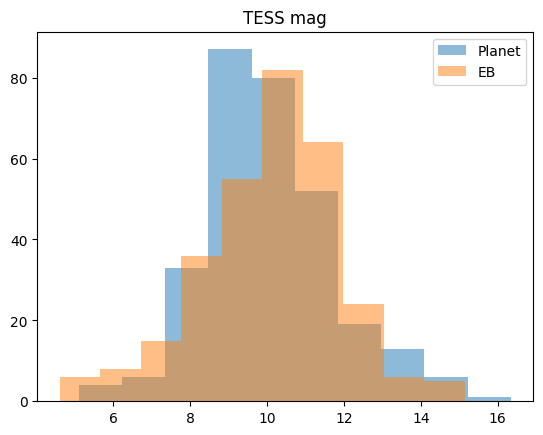

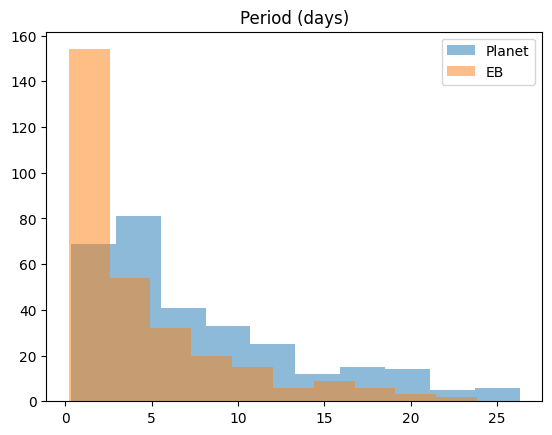

In [9]:
#Visualize the data. Are the units consistent? Do they fall in expected ranges? This is just a small example, but it is wise to explore the data in more detail.

def plot_histo(feature):
    plt.title(feature)
    plt.hist(planets[feature], alpha=0.5, label='Planet')
    plt.hist(EBs_sub[feature], alpha=0.5, label='EB')
    plt.legend()
    plt.show()
plot_histo('TESS mag')
plot_histo('Period (days)')


In [10]:
# Lets just pick one random example of each type of object to inspect what our data looks like. 
#test_eb = 'TIC 143924219'
test_eb = EBs_sub['TIC ID'][0]
search_result = lk.search_lightcurve('TIC %s'%test_eb, author='SPOC', exptime=120)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 02,2018,SPOC,120,160081043,0.0
1,TESS Sector 29,2020,SPOC,120,160081043,0.0
2,TESS Sector 69,2023,SPOC,120,160081043,0.0


Period:  [0.76870181] d
Epoch:  [1354.78903859]
Transit Duration:  [2.4573468] h


<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

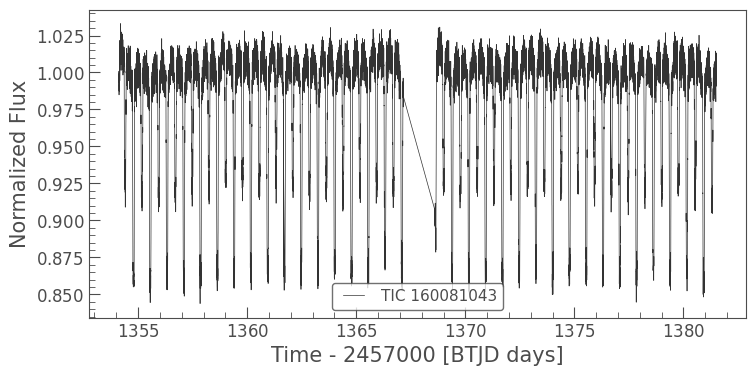

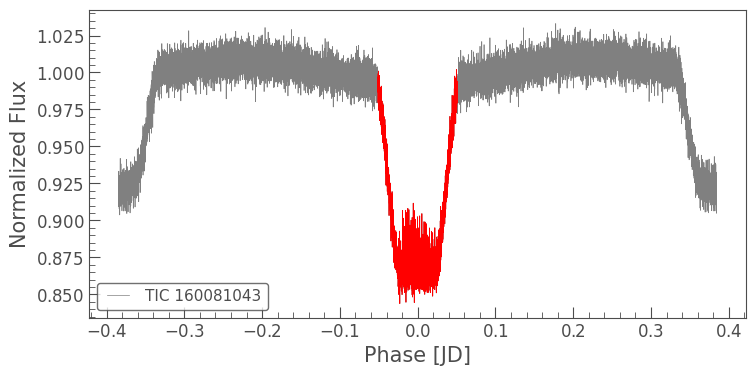

In [11]:
# Download the first available sector
EB = search_result[0].download()
EB.normalize().plot()

per = Quantity(EBs_sub[EBs_sub['TIC ID'] == test_eb]['Period (days)'],unit='day')
ep = Time(EBs_sub[EBs_sub['TIC ID'] == test_eb]['Transit Epoch (MBJD)'],format='btjd')
dur = Quantity(EBs_sub[EBs_sub['TIC ID'] == test_eb]['Duration (hours)'], unit='hour')
print('Period: ',per)
print('Epoch: ', ep)
print('Transit Duration: ', dur)
# Fold the data on the EB period and re-plot
ax = EB.normalize().fold(period = per, epoch_time = ep).plot(c='gray')

# Make a mask of the primary transit event
mask = EB.create_transit_mask(period=per, transit_time = ep, duration= dur)

EB.normalize()[mask].fold(period=per, epoch_time = ep).plot(ax = ax, c='red', ms=10, label=None)

In [12]:
test_planet = planets['TIC ID'][0]
search_result = lk.search_lightcurve('TIC %s'%test_planet, author='SPOC', exptime=120)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,SPOC,120,266980320,0.0
1,TESS Sector 28,2020,SPOC,120,266980320,0.0
2,TESS Sector 68,2023,SPOC,120,266980320,0.0


<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

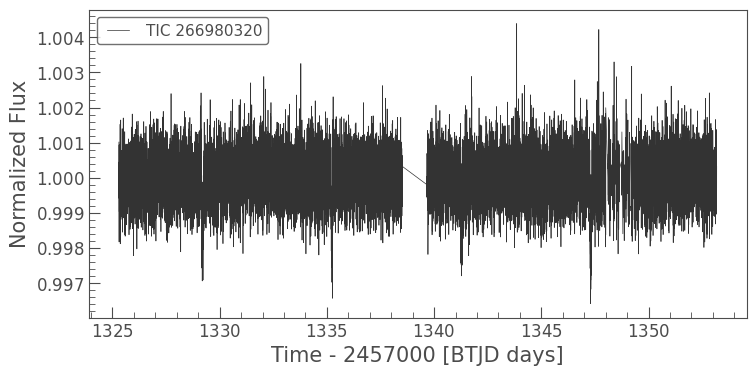

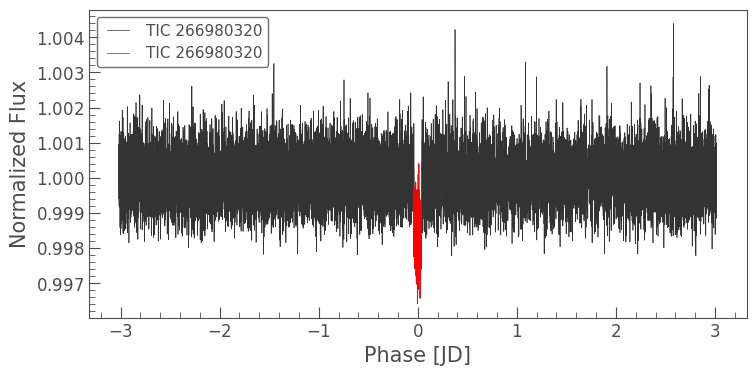

In [13]:
planet = search_result[0].download()
planet.normalize().plot()

per = Quantity(planets[planets['TIC ID'] == test_planet]['Period (days)'],unit='day')
ep = Time(planets[planets['TIC ID'] == test_planet]['Transit Epoch (MBJD)'],format='btjd') 
dur = Quantity(planets[planets['TIC ID'] == test_planet]['Duration (hours)'], unit='hour')

ax = planet.normalize().fold(period=per, epoch_time = ep).plot()

mask = planet.create_transit_mask(period=per,
                   transit_time = ep,
                   duration= dur)

planet.normalize()[mask].fold(period=per, 
                   epoch_time = ep).plot(ax=ax,c='red')

# Step 4 - prepare the data for machine learning

We will create two datasets, one with metadata describing the object's transit, and the other binned lightcurve data. 

Note that we aren't doing any special pre-processesing of the metadata values at all, but ML methods like having nice normalized data. Check out https://scikit-learn.org/stable/modules/preprocessing.html and try your hand and preparing the data.

In [14]:
# Add in the 'ground truth' labels so we can measure the performance
EBs_sub['label'] = ['EB']*len(EBs_sub)
planets['label'] = ['P']*len(planets)

# Common features from the two datasets
shared_keys = ['label','TIC ID', 'PM RA (mas/yr)','PM Dec (mas/yr)','TESS mag', 'Transit Epoch (MBJD)','Period (days)','Duration (hours)','Depth (mmag)']

meta = pd.concat([EBs_sub[shared_keys], planets[shared_keys]], ignore_index=True)
meta.head()

,label,TIC ID,PM RA (mas/yr),PM Dec (mas/yr),TESS mag,Transit Epoch (MBJD),Period (days),Duration (hours),Depth (mmag)
0,EB,160081043,0.072034,-12.82620,12.9518,1354.789039,0.768702,2.457347,155.268611
1,EB,24935204,-15.578500,-15.58510,10.5568,1765.566709,13.443185,5.794416,475.925191
2,EB,11002748,3.477800,-3.35389,11.6115,1438.415691,0.778715,2.885294,133.193778
3,EB,62762261,22.551200,-53.77160,10.2708,1332.168670,19.158835,8.099322,162.234360
4,EB,260131665,-4.100000,6.50000,5.3885,1599.678685,1.672535,5.426946,122.386978


For supervised learning (when using a dataset with known labels to train the model, as we are doing here), it is essential that your training data is not used at all when testing your model. This would lead to a false and overly optimistic evaluation of your model. An easy way to split up the data is with sklearn's train_test_split function, where you can provide the relative size of your datasets. Here we shuffle the data so that we get a random slection of EBs and planets.

In this notebook we will only implement the most basic algorithms. It is worth playing around with the models, tweaking different hyperparameters and tracking the model performance across the changes. 

In [15]:
train, test = train_test_split(meta, train_size=0.8, shuffle=True)
print(len(train), len(test))

481 121


In [16]:
#Separate the metadata from the label data. 
def prep_data(df):
    df = df.dropna().reset_index()
    y = df[['TIC ID','label']]
    X = df.drop(columns=['TIC ID','label', 'index'])
    return (y, X)

y_train_meta, X_train_meta = prep_data(train)
y_test_meta, X_test_meta = prep_data(test)
print(len(X_train_meta), len(X_test_meta))

# Convert the label strings to binary values needed for ML
# This is a super handy tool for doing this easily. You can even save out your encoder to use later. 
le = LabelEncoder()
le.fit(y_train_meta['label'])
le.classes_

481 121


array(['EB', 'P'], dtype=object)

In [17]:
#Let's look at what our final dataset looks like
X_train_meta.head()

,PM RA (mas/yr),PM Dec (mas/yr),TESS mag,Transit Epoch (MBJD),Period (days),Duration (hours),Depth (mmag)
0,21.674300,16.4314,10.6765,1438.619717,0.660839,1.774891,550.340018
1,8.500000,-3.3000,7.7137,1683.511383,1.540394,2.153057,78.881723
2,-0.130671,-2.0623,11.8529,1684.601438,1.966623,6.373138,126.784132
3,5.178000,20.7725,9.9909,1468.583338,0.760252,0.683759,1.977785
4,149.953000,-87.2530,10.4200,1354.552190,20.708504,2.236524,1.800631


In [18]:
y_train_meta.head()

,TIC ID,label
0,143350469,EB
1,121020626,EB
2,121457732,EB
3,219403686,EB
4,251848941,P


Now it's time to put your TESS knowledge to use. We want to make a dataset that contains the the local and global lightcurves. I recommend making a CSV containing at least columns containing the TIC ID, the label, and the lightcurve (one column per bin). The columns need to be in the same length.

I am including pre-generated results from a very rudimentary binning model I made to provide a starting point. I did no checking of the data so it handles problems in the data, such a gaps in the observations, rather poorly, which is particularly egregious in the local lightcurves. I also did not normalize the data nicely (check out the lightkurve tutorial on preparing data for machine learning to get some ideas). 

These steps are purposely not taken as this is meant to be a starting point. This also demonstrates that carefully constructing your input data is pivotal for a well performing model. Your model that you create below should take some of these known problems into account. You can compare the final performance using my bad data and your much better data to see the difference. 

In [19]:
# Bin and fold the lightcurves. You can change these lengths to what you think is reasonable given your data. 

global_len = 400
local_len = 100

def get_lightcurves():
    # Write your binning functions here! 
    # Remember, the global lightcurve is the full phase-folded lightcurve binned to global_len bins
    # The local lightcurve is zoomed into the the transit event. The cutout region should be relative to the transit duration.
    return (global_lc, local_lc)


# Wrapper function to create lightcurves from your training or test dataset
def prep_nn_timeseries():
    # Call the binning function you wrote above and save out a csv file
    return #global_lcs, local_lcs

# If you want to use the same training/test sets as for the RF, pass the TIC IDs to your function so you get the same targets

# Note, reading in all of the fits files can take a bit of time, so I'd save out your csv to use next time you run the notebook. 

In [20]:


if len(glob.glob('workshop_material/global_lc_train.csv')) == 1:
    print('Training data already exists, reading it in now...')
    train_lcs_global = pd.read_csv('workshop_material/global_lc_train.csv', header=None)
    train_lcs_local = pd.read_csv('workshop_material/local_lc_train.csv', header=None)
else:
    prep_nn_timeseries(y_train_meta, train=True)
    train_lcs_global = pd.read_csv('workshop_material/global_lc_train.csv', header=None)
    train_lcs_local = pd.read_csv('workshop_material/local_lc_train.csv', header=None)
    
    
if len(glob.glob('workshop_material/global_lc_test.csv')) == 1:
    print('Testing data already exists, reading it in now...')
    test_lcs_global = pd.read_csv('workshop_material/global_lc_test.csv', header=None)
    test_lcs_local = pd.read_csv('workshop_material/local_lc_test.csv', header=None)
else:
    prep_nn_timeseries(y_test_meta, train=False)
    test_lcs_global = pd.read_csv('workshop_material/global_lc_test.csv', header=None)
    test_lcs_local = pd.read_csv('workshop_material/local_lc_test.csv', header=None)

Training data already exists, reading it in now...
Testing data already exists, reading it in now...


In [21]:
#Now lets check the shape of our training and test datasets. 
#Keeping track of your data shapes is very important for neural networks, so get in the habit of checking. 
#Should be of the shape (number_of_samples, global_len+2), assuming you only added TIC ID and label
print(train_lcs_global.shape)
print(train_lcs_local.shape)
print(test_lcs_global.shape)
print(test_lcs_local.shape)

(258, 402)
(258, 102)
(56, 402)
(56, 102)


In [22]:
# Get rid of any rows that contain nans if you have any. NaNs will make your CNN unhappy (try leaving them in to see what happens)
nan_mask = train_lcs_local.isna().any(axis=1) + train_lcs_global.isna().any(axis=1)
print('your training data has %s lightcurves filled with nans.'%sum(nan_mask))
train_lcs_global = train_lcs_global[~nan_mask]
train_lcs_local = train_lcs_local[~nan_mask]

nan_mask = test_lcs_local.isna().any(axis=1) + test_lcs_global.isna().any(axis=1)
print('your test data has %s lightcurves filled with nans.'%sum(nan_mask))
test_lcs_global = test_lcs_global[~nan_mask]
test_lcs_local = test_lcs_local[~nan_mask]

your training data has 14 lightcurves filled with nans.
your test data has 5 lightcurves filled with nans.


In [23]:
# Reshape the data so they are in the format keras wants. Getting all the data in the right format is (more than) half the battle with keras!
# THIS ASSUMES YOUR CSV HAS COLUMNS IN THE ORDER TIC ID, LABEL, LIGHTCURVE of length n
x_train_global = train_lcs_global.values[:,2:].reshape((train_lcs_global.values[:,2:].shape[0], train_lcs_global.values[:,2:].shape[1], 1))
x_test_global = test_lcs_global.values[:,2:].reshape((test_lcs_global.values[:,2:].shape[0], test_lcs_global.values[:,2:].shape[1], 1))

x_train_local = train_lcs_local.values[:,2:].reshape((train_lcs_local.values[:,2:].shape[0], train_lcs_local.values[:,2:].shape[1], 1))
x_test_local = test_lcs_local.values[:,2:].reshape((test_lcs_local.values[:,2:].shape[0], test_lcs_local.values[:,2:].shape[1], 1))

print(x_train_global.shape, x_test_global.shape)
print(x_train_local.shape, x_test_local.shape)

(244, 400, 1) (51, 400, 1)
(244, 100, 1) (51, 100, 1)


In [24]:
# Remember, our Y data cas a column for tic id and label
y_train = train_lcs_local.values[:,1]
y_test = test_lcs_local.values[:,1]



# Step 5 - Create your ML models

In [25]:
# Create an RFC with 25 trees in the forest. It's really that easy!
# See the sklearn documentation for other tuning parameters
clf = RandomForestClassifier(n_estimators = 25) 
clf.fit(X_train_meta.to_numpy(), le.transform(y_train_meta['label']))
y_pred_rfc = clf.predict(X_test_meta.to_numpy())

Let's look at our results. A classic way to look at classification results is with a confusion matrix, where we compare the ground truth with the model output. Correct labels will fall on the top-left to bottom-right diagonal, while wrong prediction are off the diagonal. Let's see how our model performed. 

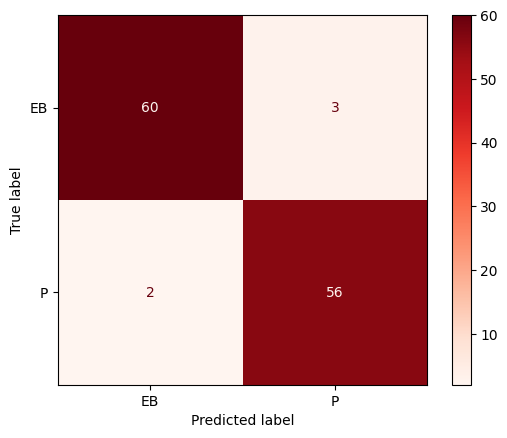

In [26]:
cm = confusion_matrix(le.transform(y_test_meta['label']), y_pred_rfc)
ConfusionMatrixDisplay(cm,display_labels=le.classes_).plot(cmap='Reds')

Looks pretty good! There are lots of other ways to evaluate your model (precision, recall, F1 score,...) Check out the sklearn documentation and try a few of them out here. Depending on the goal of your model, the metric you end us using may change. Keep in mind, this is also using a very small number of features. You can improve this dataset by adding more features from information contained in the TESS fits header of each star, or even query another catalog like Gaia. The sky is the limit here. The good the about RFCs is that they are pretty robust to non-relavant data, so there isn't a lot of harm in trying out many different features. 

Creating a neural network is a bit more involved. Below I've included two different models, one that takes only the local lightcurve as input and the second that considers both the global and local view. Note that several authors (e.g. Ansdell et al, 2018; Osborn et al 2020) have noted that including additional information will improve the results. This can include lightcurve centroid information (tracking how the center of light in the pixel shifts during the transit, which can expose blended sources). It is also a great idea to incorporate the meta data into the NN model. Can you modify the code below to make these changes?

In [27]:
def single_input_model():
    # Input layer gives the shape of your data. 
    input_layer = keras.layers.Input(shape = (global_len,1))

    # These are the convolutional layers. Notice you can change the number of filters, kernel size, etc
    # I didn't do any dropout layers here (helps with overfitting). Can you put them in?
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)
    
    # The dense layers are the ordinary neural network layers
    dense1 = keras.layers.Dense(256, activation='relu')(gap)
    
    # for a binary classifier, the output layer size is 1, as the output is a single number between 0 and 1. 
    # A sigmoid activation function is good for a binary output layer. Can you figure out why that might be the case?
    output_layer = keras.layers.Dense(1, activation="sigmoid")(dense1)
    
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(
    optimizer='adam',
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
    return model


def multi_input_model():
    # Now we have 2 inputs, the global light curves and the local light curves
    inputA = keras.layers.Input(shape=(global_len,1))
    inputB = keras.layers.Input(shape=(local_len,1))
    
    # Convolutions on the global lc
    A = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(inputA)
    A = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(A)
    #A = keras.layers.ReLU()(A)
    A = keras.layers.MaxPooling1D(pool_size=3, strides=2)(A)
    A = keras.layers.Dropout(0.2)(A)
    A = keras.layers.Flatten()(A)
    A = keras.models.Model(inputA, A)
    
    # Convolutions on the local lc
    B = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(inputB)
    B = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(B)
    #B = keras.layers.ReLU()(B)
    B = keras.layers.MaxPooling1D(pool_size=3, strides=2)(B)
    B = keras.layers.Dropout(0.2)(B)
    B = keras.layers.Flatten()(B)
    B = keras.models.Model(inputB, B)
    
    # Combine the two convolution branches before entering the dense layers
    combined = keras.layers.concatenate([A.output, B.output])

    
    C = keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal')(combined)
    C = keras.layers.Dropout(0.2)(C)
    C = keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal')(C)
    C = keras.layers.Dropout(0.2)(C)
    C = keras.layers.Dense(1, activation='sigmoid')(C)
    model = keras.models.Model(inputs=[A.input, B.input], outputs=C)
    
    model.compile(
    optimizer=keras.optimizers.Adamax(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
    return model

'''input_model = single_input_model()
history = input_model.fit(
    x_train_global.astype('float32'),
    le.transform(y_train),
    batch_size=20,
    epochs=25,
    validation_split=0.2,
    verbose=1,
)'''

input2_model = multi_input_model()
history = input2_model.fit(
    [x_train_global.astype('float32'), x_train_local.astype('float32')],
    le.transform(y_train),
    batch_size=20,
    epochs=25,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.4881 - loss: 1.0768 - val_accuracy: 0.4286 - val_loss: 0.7460
Epoch 2/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.5062 - loss: 0.6978 - val_accuracy: 0.5714 - val_loss: 0.6732
Epoch 3/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.4798 - loss: 0.7177 - val_accuracy: 0.8367 - val_loss: 0.6819
Epoch 4/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.5308 - loss: 0.6981 - val_accuracy: 0.5714 - val_loss: 0.6689
Epoch 5/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.5879 - loss: 0.6668 - val_accuracy: 0.4286 - val_loss: 0.6806
Epoch 6/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.5615 - loss: 0.6792 - val_accuracy: 0.5918 - val_loss: 0.6664
Epoch 7/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.5077 - loss: 0.6963 - val_accuracy: 0.8980 - val_loss: 0.6747
Epoch 8/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.6144 - loss: 0.6622 - val_accuracy: 0.5918 -

In [28]:
#y_pred_CNN = input_model.predict(x_test_global.astype('float32'))
y_pred_CNN = input2_model.predict([x_test_global.astype('float32'), x_test_local.astype('float32')])
print(y_pred_CNN[:5])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
[[0.65466315]
 [0.6806524 ]
 [0.6782269 ]
 [0.46365836]
 [0.68667775]]


This doesn't look like the binary outputs we expected to convert back into classes. That's because the final layer of our model uses a sigmoid activation function, so the 'prediction' is a value between 0 and 1 and can be treated like a probability score, with values closer to 0 or 1 being more confident in the prediction. Let's binarize it by making the cutoff threshold 0.5.



In [29]:
y_pred_CNN_binary = [1 if x >=0.5 else 0 for x in y_pred_CNN]

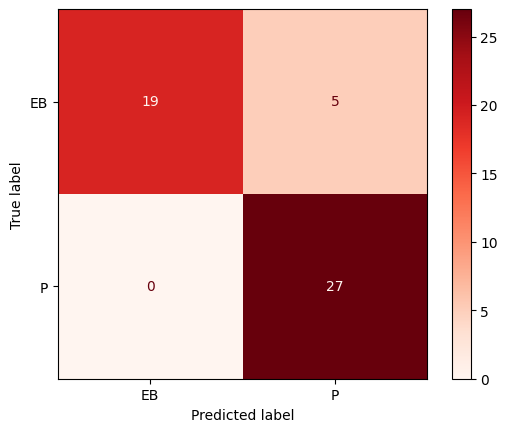

In [30]:
cm = confusion_matrix(le.transform(y_test), y_pred_CNN_binary)
ConfusionMatrixDisplay(cm,display_labels=le.classes_).plot(cmap='Reds')

The performance doesn't quite match the simple RFC. However, for this model, no hyperparameter tuning was done (batch size, number of epochs, size and number of convolutional and dense layers, etc). Try testing out different configurations to see how it goes - you can definitely improve this result! But remember, you don't want to be dealing with the test dataset until all of your models have been trained and you are ready for final production. Instead of using the confusion matrix like above for each model, pay attention to the val_accuracy that gets spit out with each of your epochs. Each epoch pulls out a validation set from the training data to check the progress on 'fresh' data. 

# Step 6 - analysis

Let's take a look at a few other measures to try to understand our data a little more. First, let's look at the RFC. One of the reasons RFCs are extremely popular, other than their sheer simplicity, is that the creation of the model gets you a measure of the importance of each of the input features to making correct predictions. This can give some insight into what the model is picking up on. Let's plot that here. What conclusions can you make based on these results? Try adding more features and see how this changes. 

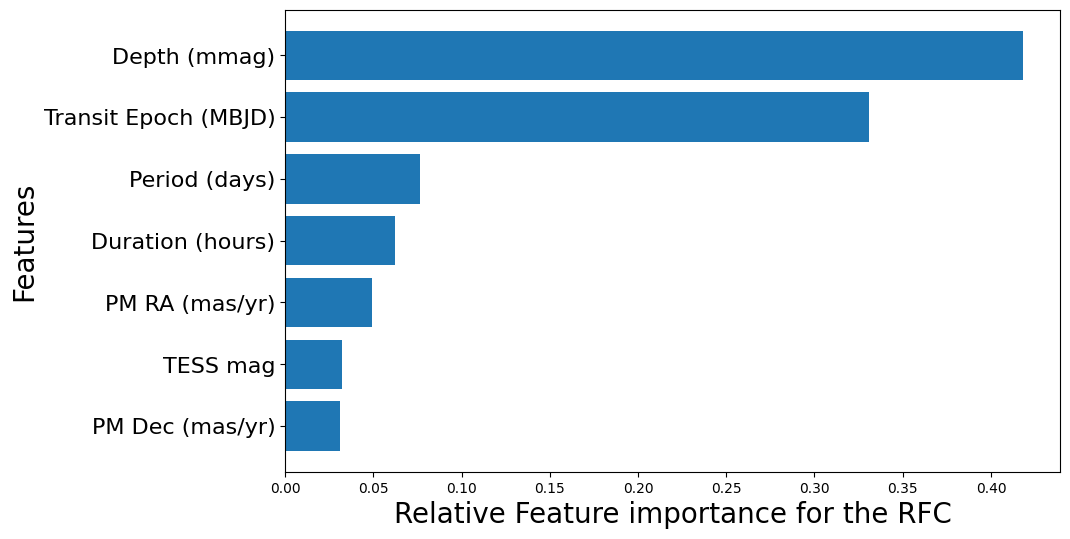

In [31]:
importance_list, zipped_name_list = zip(*sorted(zip(clf.feature_importances_, X_train_meta.columns)))

fig, ax = plt.subplots(figsize=(10,6))
ax.barh(range(len(zipped_name_list)), importance_list, align='center')
ax.set_yticks(range(len(zipped_name_list)), zipped_name_list, size=16)
ax.set_xlabel('Relative Feature importance for the RFC', fontsize=20)
ax.set_ylabel('Features', fontsize=20)
plt.show()

Another very popular visualization is called the Receiver Operating Characteristic (ROC) curve and the related Area Under the Curve (https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5). Let's implement this for our models. Note we use our RFC again but calling predict_proba() rather than just predict() as we did above because we want to see how changing the prediction threshold changes the outcome, which isn't possible with just the binary prediction. 

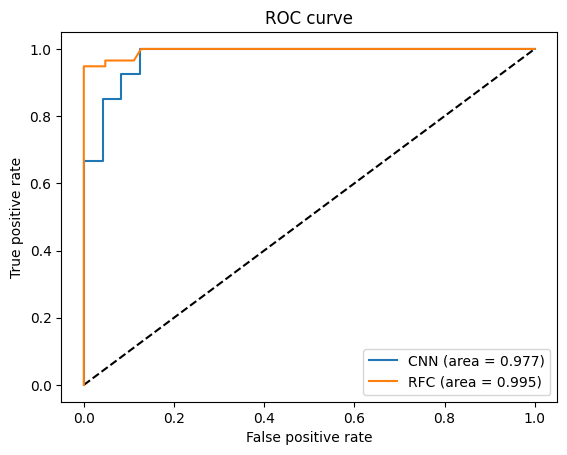

In [32]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(le.transform(y_test), y_pred_CNN)
auc_keras = auc(fpr_keras, tpr_keras)

rfc_proba = clf.predict_proba(X_test_meta.to_numpy())[:,1]

fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(le.transform(y_test_meta['label']), rfc_proba)
auc_rfc = auc(fpr_rfc, tpr_rfc)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='CNN (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rfc, tpr_rfc, label='RFC (area = {:.3f})'.format(auc_rfc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

How do your models look? If all goes as expected, they should both be performing quite well. This is to be expected as most EBs have substantially deeper transits than planets. You can explore the data more, and even look at the lightcurves and metadata for samples the models got wrong to see if there is something obvious going on that could be improved. 

This hackathon notebook has just touched on a few points in the much larger field of machine learning. There is so much to explore! The great thing about machine learning is that once you learn the mechanics, you can apply it to new datasets quite seamlessly. But remember, the feature engineering is very important, so you will still need to spend plenty of time preparing your datasets. 

REFERENCES: 
    
Machine learning is a rapidly evolving subject, so keeping up with the latest models can be difficult. But there are tons of great resources out there. I tend to start with searching the internet for blog posts about the method you are interested in and following the links from there to find out more. There are also really good youtube tutorials that you can find. It is well worth some time learning about the basics of a variety of different methods. 

Once you're familiar with the concepts, you can check out some TESS-related projects relating to machine learning

Yu et al (2019) Identifying Exoplanets with Deep Learning. III. Automated Triage and Vetting of TESS Candidates - https://ui.adsabs.harvard.edu/abs/2019AJ....158...25Y/abstract

Osborn et al (2020) Rapid classification of TESS planet candidates with convolutional neural networks - https://ui.adsabs.harvard.edu/abs/2020A%26A...633A..53O/abstract

Rao et al (2021) Nigraha: Find and evaluate planet candidates from TESS light curves - https://ui.adsabs.harvard.edu/abs/2021MNRAS.502.2845R/abstract

Olmschenk et al (2021) Identifying Planetary Transit Candidates in TESS Full-frame Image Light Curves via Convolutional Neural Networks - https://ui.adsabs.harvard.edu/abs/2021AJ....161..273O/abstract

Hon et al (2021) A "Quick Look" at All-sky Galactic Archeology with TESS: 158,000 Oscillating Red Giants from the MIT Quick-look Pipeline - https://ui.adsabs.harvard.edu/abs/2021ApJ...919..131H/abstract

Feinstein et al (2022) Testing Self-organized Criticality across the Main Sequence Using Stellar Flares from TESS - https://ui.adsabs.harvard.edu/abs/2022ApJ...925L...9F/abstract

Olmschenk et al (2024) Short-period Variables in TESS Full-frame Image Light Curves Identified via Convolutional Neural Networks - https://ui.adsabs.harvard.edu/abs/2024AJ....168...83O/abstract

And many more! 


